- ##### Tuscano Alessio
- ##### Tramarin Chiara

# 8-Bit CPU Emulator (SAP-1) - MAPD-A PROJECT 



### Project Overview: 8-Bit CPU Emulation

This project emulates an **8-bit CPU**, inspired by the SAP-1 model, with a clock-by-clock cycle simulation. By replicating the instruction cycle at a granular level, this approach enables detailed observation of how each CPU component operates during the distinct phases of instruction execution, including both the fetch and execution cycles. The emulation uses a software-based approach to mimic hardware functionality, with key components implemented as Python classes. These include:  
- **Registers**: Accumulator, B Register, Instruction Register (IR), ProgramCounter (PC).  
- **Memory**: RAM and the Memory Address Register (MAR).  
- **ALU**: An Arithmetic Logic Unit for addition and subtraction.  
- **Control Units**: The Controller and Sequencer (CPU() in the code).

### CPU Instruction Execution

The CPU processes instructions in three fundamental stages:

1. **Fetch**:  
   The Program Counter (PC) provides the address of the next instruction to the Memory Address Register (MAR). The memory retrieves the instruction from this address, which is then loaded into the Instruction Register (IR).  

2. **Decode**:  
   The Controller interprets the instruction in the IR to determine the operation to execute. It generates the necessary control signals to guide other components.

3. **Execute**:  
   Data from the registers (e.g., Accumulator, B Register) is processed by the ALU or other components, and the results are stored or used to update other registers.

---

### Key Implementation Steps

To build this emulator, we followed a structured process:  

1. **Component Behavior Definition**:  
   We defined how each component functions, such as how registers update, how data transfers between RAM and registers, and how the ALU processes data.  

2. **Micro-Operation Decomposition**:
   Each instruction was broken down into **micro-operations** that are executed across clock cycles.
   The SAP1 processes a total of **five instructions** (LDA, ADD, SUB, OUT, HLT).  
   - All instructions, except **HLT**, require a total of **six clock cycles** to execute: three clock cycles for the **fetch cycle**, which is identical for all instructions, and three clock cycles for the **execution cycle**, which varies based on the specific operation.
     
   - **T1-T3: Fetch Cycle (T1-T3)**  
     -  **T1**: The address of the next instruction, held in the Program Counter (PC), is sent to the Input and MAR.  
     -  **T2**:The PC is incremented to point to the subsequent instruction.
     -  **T3**: The RAM retrieves the instruction from the address provided by the MAR. The instruction is placed on the bus and then stored in the Instruction Register (IR).
       
   - **Execution Cycle (T4-T6)**: Specific to each instruction. For example for the **LDA (Load)** Instruction:  
       - **T4**: The MAR retrieves the operand’s address from the IR.  
       - **T5**: The RAM loads the operand into the bus, which then sends it to the Accumulator.  
       - **T6**: A No-Operation (NOP) state is used to synchronize and prepare the system for the next instruction.  


4. **Clock Simulation**:  
   The emulator uses a counter to simulate clock cycles. During each clock cycle, all components (PC, IR, registers, MAR, ALU, and bus) are updated, and their states are visualized, providing a detailed view of the fetch and execution phases for every instruction.

---

### Key Technical Details

**8-Bit Architecture**:  
   - The registers (Accumulator, B Register, and IR) are 8 bits wide, allowing values from 0 to 255 (unsigned) or -128 to 127 (signed using two's complement).  
   - The **RAM** stores 8-bit data at each of its 16 addresses.  
   - The **ALU** performs addition and subtraction on 8-bit operands.
     


**4-Bit Registers**:  
   - The **Program Counter (PC)** is a 4-bit register, as the CPU only addresses 16 memory locations.
   - This limited address space is sufficient for the scope of this simplified emulation.
  
     
Below, we include a simplified schema of the SAP 1 for reference. 

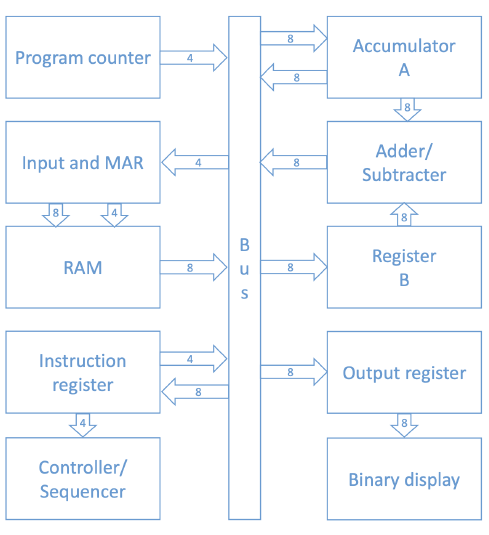

In [1]:
from IPython.display import Image, display
display(Image("C:/Users/chiar/OneDrive/Desktop/sap1.png", width=400))       

In [2]:
# Utility Functions
def binary_to_decimal(binary_string):
    """
    Converts a binary string to its decimal equivalent.
    Handles two's complement for negative numbers.
    """
    if binary_string[0] == '1':  # Negative number in two's complement
        return int(binary_string, 2) - 2**len(binary_string)
    else:
        return int(binary_string, 2)

def decimal_to_binary(decimal_number, bit_width=8):
    """
    Converts a decimal number to a binary string.
    Pads the result to match the specified bit width.
    """
    if decimal_number < 0:  # Handle negative numbers
        binary_string = bin(decimal_number + 2**bit_width)[2:]
    else:
        binary_string = bin(decimal_number)[2:]
    return binary_string.zfill(bit_width)

In [3]:
## CLASSES ##

# Base Register Class
class Register:
    """
    General-purpose base class for all registers.
    """
    def __init__(self):
        self.state = ''  # Initialize with an empty state

    def read(self):
        """Reads the current state of the register."""
        return self.state

    def write(self, data):
        """Writes data into the register."""
        self.state = data

    def __str__(self):
        return f"State: {self.state}"

# 8-bit and 4-bit Registers
class ByteRegister(Register):
    """8-bit register implementation."""
    def __init__(self):
        self.state = '0' * 8  # Initialize as an 8-bit binary string

    def __str__(self):
        return f"State: {self.state}"

class NibbleRegister(Register):
    """4-bit register implementation."""
    def __init__(self):
        self.state = '0' * 4  # Initialize as a 4-bit binary string

    def __str__(self):
        return f"State: {self.state}"
        

# Random Access Memory (RAM)
class RAM(Register):
    """
    RAM implementation with 16 addresses, each storing 8-bit data.
    """
    def __init__(self):
        self.state = [ByteRegister() for _ in range(16)]  # Initialize 16 addresses

    def write(self, data, address):
        """Writes 8-bit data to the specified memory address."""
        assert type(data) is str, 'Data must be a string.'
        assert len(data) == 8, 'Data size must be 8 bits.'
        self.state[address].write(data)

    def read(self, address):
        """Reads 8-bit data from the specified memory address."""
        return self.state[address].read()

    def __str__(self):
        return "\n".join([f"Address {i}: {register}" for i, register in enumerate(self.state)])

# Instruction Register (IR)
class InstructionRegister(ByteRegister):
    """
    Specialized 8-bit register to store the current instruction.
    Provides methods to extract opcode and operand.
    """
    def readOpCode(self):
        """Extracts the opcode (first 4 bits) from the instruction."""
        return self.read()[:4]

    def readOperand(self):
        """Extracts the operand (last 4 bits) from the instruction."""
        return self.read()[4:]

    def __str__(self):
        return f"OpCode: {self.readOpCode()}\nOperand: {self.readOperand()}"

# Program Counter (PC)
class ProgramCounter(NibbleRegister):
    """
    4-bit Program Counter to hold the address of the next instruction.
    """
    def advance(self):
        """Advances the PC value, cycling back to 0 after 15."""
        value = int(self.state, 2)
        value = (value + 1) % 2**4  # Increment with wrap-around
        self.state = bin(value)[2:].zfill(4)

    def __str__(self):
        return f"Value: {int(self.state, 2)}"

# Arithmetic Logic Unit (ALU)
class ALU(ByteRegister):
    """
    8-bit ALU capable of addition and subtraction.
    """
    def __init__(self, aRegister, bRegister):
        self.a = aRegister  # Reference to the accumulator
        self.b = bRegister  # Reference to the B register
        self.state = '0' * 8  # Initialize ALU state

    def update(self, mode='add'):
        """Performs addition or subtraction based on the mode."""
        value_a = binary_to_decimal(self.a.read())
        value_b = binary_to_decimal(self.b.read())
        result = value_a + value_b if mode == 'add' else value_a - value_b
        self.state = decimal_to_binary(result)[0:8]

    def read(self, mode='add'):
        """Updates and returns the result of the operation."""
        self.update(mode)
        return self.state

    def __str__(self):
        self.read()  # Ensure the state is updated
        return self.state


In [4]:

# Central Processing Unit (CPU)
class CPU:
    """
    8-bit CPU emulator inspired by the SAP-1 model.
    """
    def __init__(self):
        # Initialize components
        self.clock = 0 #counter to simulate clock cycles, incremented every time a micro-instruction in made
        self.ram = RAM()
        self.aRegister = ByteRegister()  # Accumulator
        self.bRegister = ByteRegister()
        self.programCounter = ProgramCounter()
        self.instructionRegister = InstructionRegister()
        self.alu = ALU(self.aRegister, self.bRegister)

        # Instruction-to-microinstructions mapping
        self.macro_instructions = {
            "LDA": [self.ir_to_mar, self.ram_to_a, self.no_op],
            'ADD': [self.ir_to_mar, self.ram_to_b, self.alu_to_a_add],
            'SUB': [self.ir_to_mar, self.ram_to_b, self.alu_to_a_sub],
            "OUT": [self.a_to_out, self.no_op, self.no_op],
            "HLT": [self.no_op],
        }

        # Mnemonic-to-opcode mapping
        self.mnemo_op_code = {
            "LDA": "0000",
            "ADD": "0001",
            "SUB": "0010",
            "OUT": "1110",
            "HLT": "1111",
        }

        # Opcode-to-mnemonic mapping
        self.op_code_mnemo = {v: k for k, v in self.mnemo_op_code.items()}



    # Micro-instructions
    def pc_to_mar(self):
        self.clock += 1
        self.memory_address = int(self.programCounter.read(), 2)
        self.print_state()

    def ram_to_ir(self):
        self.clock += 1
        self.instructionRegister.write(self.ram.read(self.memory_address))
        self.print_state()

    def ir_to_mar(self):
        self.clock += 1
        self.memory_address = int(self.instructionRegister.readOperand(), 2)
        self.print_state()

    def ram_to_a(self):
        self.clock += 1
        self.aRegister.write(self.ram.read(self.memory_address))
        self.print_state()

    def a_to_ram(self):
        self.clock += 1
        self.ram.write(self.aRegister.read(), self.memory_address)
        self.print_state()

    def ram_to_b(self):
        self.clock += 1
        self.bRegister.write(self.ram.read(self.memory_address))
        self.print_state()

    def ir_to_pc(self):
        self.clock += 1
        self.programCounter.write(self.instructionRegister.readOperand())
        self.print_state()

    def alu_to_a_add(self):
        self.clock += 1
        self.aRegister.write(self.alu.read('add'))
        self.print_state()

    def alu_to_a_sub(self):
        self.clock += 1
        self.aRegister.write(self.alu.read('sub'))
        self.print_state()

    def a_to_out(self):
        self.clock += 1
        print(f'OUT: {self.aRegister}')
        self.print_state()
    
    def no_op(self):
        self.clock += 1
        self.print_state()
        pass
    '''
    def halt(self):
        self.clock += 1
        print("Execution halted.")
    '''
    def execute_instruction(self, mnemonic):
        for micro_inst in self.macro_instructions[mnemonic]:
            micro_inst()
    
    def load_program(self, program):
        """Loads a program into RAM."""
        for address, instruction in enumerate(program):
            self.ram.write(instruction, address)


    def execute_opcode(self):
        # Leggi l'op-code dall'Instruction Register
        op_code = self.instructionRegister.readOpCode()
        
        # Decodifica l'op-code in un mnemonico
        if op_code in self.op_code_mnemo:
            mnemonic = self.op_code_mnemo[op_code]
        else:
            print(f"Error: Op-code {op_code} not recognised!")
            return
        
        # Esegui la macroistruzione corrispondente
        self.execute_instruction(mnemonic)
    
    def run(self, clock_cycles):
        """Runs the CPU for a specified number of clock cycles."""
        # The clock counter (`self.clock`) is incremented with each micro-instruction, simulating CPU time advancement.
        self.print_state()
        
        while self.clock < clock_cycles:  # Limit clock cycles for demonstration
            
            # Fetch cycle
            
            self.pc_to_mar()
            #self.clock += 1

            self.programCounter.advance()
            self.clock +=1
            self.print_state()
            
            self.ram_to_ir()
            #self.clock += 1
            
            
            #self.clock += 1
   
            ''' 
            One possibility was to execute the instruction THEN raise the clock by 3 all at once, 
            but it does not follow the logic of the SAP-1, instead we update the clock counter for EVERY operation inside them, 
            so we do not need to count it 'manually' here, but it is debatable.

            We choose to increment clock cycle inside each micro operation to ensure a smooth ride,
            and at the same time after trying to visualize better the data we gave up and chose to print
            every state at every micro operation performed (the program counter is done by hand as we did not want to change the
            classes structure).
            
            # Execution cycle
            self.execute_opcode()
            self.clock += 3
            '''
            
            # Stop execution if HLT was executed
            if self.instructionRegister.readOpCode() == "1111":  # HLT opcode
                print("Execution halted.")
                self.clock += 1
                self.print_state()
                break
            
            self.execute_opcode()
            
            
    def __str__(self):
        return f"Clock: {self.clock}\nRAM:\n{self.ram}\nA: {self.aRegister}\nB: {self.bRegister}"

    
    def print_state(self):
        print(f"Clock Cycle: {self.clock}")
        print(f"Program Counter (PC): {self.programCounter}")
        print(f"Instruction Register (IR):\n {self.instructionRegister}")
        print(f"Register A: {self.aRegister}")
        print(f"Register B: {self.bRegister}")
        print(f"RAM: {self.ram}")
        print("-" * 40)  


In [7]:
cpu = CPU()

# Machine language program
program = [
    "00001000",  # LDA 0x08
    "00011001",  # ADD 0x09
    "11100000",  # OUT
    "11110000"   # HLT
]

# This program requires n = 4 + 3*6 = 22 clock cycles

# Load the program into RAM
cpu.load_program(program)

# Initialize values in RAM
cpu.ram.write("00001110", 8)  # RAM[8] = 14
cpu.ram.write("00000010", 9)  # RAM[9] = 2


cpu.run(clock_cycles = 22)


Clock Cycle: 0
Program Counter (PC): Value: 0
Instruction Register (IR):
 OpCode: 0000
Operand: 0000
Register A: State: 00000000
Register B: State: 00000000
RAM: Address 0: State: 00001000
Address 1: State: 00011001
Address 2: State: 11100000
Address 3: State: 11110000
Address 4: State: 00000000
Address 5: State: 00000000
Address 6: State: 00000000
Address 7: State: 00000000
Address 8: State: 00001110
Address 9: State: 00000010
Address 10: State: 00000000
Address 11: State: 00000000
Address 12: State: 00000000
Address 13: State: 00000000
Address 14: State: 00000000
Address 15: State: 00000000
----------------------------------------
Clock Cycle: 1
Program Counter (PC): Value: 0
Instruction Register (IR):
 OpCode: 0000
Operand: 0000
Register A: State: 00000000
Register B: State: 00000000
RAM: Address 0: State: 00001000
Address 1: State: 00011001
Address 2: State: 11100000
Address 3: State: 11110000
Address 4: State: 00000000
Address 5: State: 00000000
Address 6: State: 00000000
Address 